In [2]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import pickle
import datetime
from utils.es_utils import *
from utils.env_utils import *
from utils.eval_utils import *
from utils.train_utils import *
from models.Buffer import Buffer
from models.PredatorPolicy import PredatorPolicy
from models.PredInteractionPolicy import PreyPolicy, PredInteractionPolicy
from models.ModularNetworks import PredatorInteraction
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
from models.Buffer import Pool
from utils.env_utils import *
from utils.eval_utils import *
from utils.train_utils import pretrain_policy_with_validation
from custom_marl_aquarium.aquarium_v0 import parallel_env

In [3]:
# Create training folder
path = rf"..\data\2. Training\training\BC"
timestamp = datetime.datetime.now().strftime("%d.%m.%Y_%H.%M")
folder_name = f"BC Training - {timestamp} - Couzin Data"
save_dir = os.path.join(path, folder_name)
os.makedirs(save_dir, exist_ok=True)

# Expert Data
traj_path = rf'..\data\1. Data Processing\processed\video\expert_tensors\yolo_detected'
couzin_path = rf'..\data\1. Data Processing\processed\couzin'
hl_path = rf'..\data\1. Data Processing\processed\video\expert_tensors\hand_labeled'
ftw_path = rf'..\data\1. Data Processing\processed\video\3. full_track_windows'

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pred_policy = PredatorPolicy().to(device)
pred_policy.set_parameters(init=True)

prey_policy = PreyPolicy().to(device)
prey_policy.set_parameters(init=True)

expert_buffer = Buffer(pred_max_length=23000, prey_max_length=250000, device="cpu")

start_frame_pool = Pool(max_length=12100, device="cpu")
start_frame_pool.generate_startframes(ftw_path)
print(f"Start frames in pool: {len(start_frame_pool)}")

Start frames in pool: 11978


In [5]:
# Load Expert Data from local storage
print("Expert Buffer is empty, load data...")
expert_buffer.add_expert(couzin_path)
#expert_buffer.clear(p=80)               # Reduce ratio of non-attack data by 90%. now ~equal
#expert_buffer.add_expert(hl_path)       # hand-labeled data | Pred: 1057 | Prey: 33824

len_exp_pred, len_exp_prey, len_exp_pred_prey = expert_buffer.lengths()
print("Storage of Predator Expert Buffer: ", len_exp_pred)
print("Storage of Prey Expert Buffer: ", len_exp_prey)
print("Storage of Prey Pred Expert Buffer: ", len_exp_pred_prey, "\n")

Expert Buffer is empty, load data...
Storage of Predator Expert Buffer:  7510
Storage of Prey Expert Buffer:  240320
Storage of Prey Pred Expert Buffer:  240320 



In [ ]:
pred_policy = pretrain_policy(pred_policy, expert_buffer, role="predator", pred_bs=32, prey_bs=256, epochs=100, lr=1e-3, device='cpu')

In [ ]:
prey_policy = pretrain_policy(prey_policy, expert_buffer, role="prey", pred_bs=32, prey_bs=256, epochs=100, lr=1e-3, device='cpu')

In [ ]:
prey_pred_policy = PredInteractionPolicy().to(device)
prey_pred_policy.set_parameters(init=True)

prey_pred_policy = pretrain_policy(prey_pred_policy, expert_buffer, role="prey_pred", pred_bs=32, prey_bs=256, epochs=100, lr=1e-3, device='cpu')

Len Mu 32
Mu:  tensor([[-0.1469],
        [-0.0629],
        [-0.0950],
        [-0.0865],
        [-0.1038],
        [-0.1122],
        [-0.1471],
        [-0.1465],
        [-0.1634],
        [-0.1200],
        [-0.1216],
        [-0.1219],
        [-0.0669],
        [-0.1312],
        [-0.1556],
        [-0.1773],
        [-0.0872],
        [-0.1426],
        [-0.1802],
        [-0.0853],
        [-0.1399],
        [-0.0448],
        [-0.0750],
        [-0.0800],
        [-0.1627],
        [-0.0963],
        [-0.0981],
        [-0.0727],
        [-0.1487],
        [-0.0375],
        [-0.1401],
        [-0.0465]], grad_fn=<SliceBackward0>)
 Sigma:  tensor([[0.8513],
        [0.7862],
        [0.8437],
        [0.7922],
        [0.8087],
        [0.8556],
        [0.8117],
        [0.8057],
        [0.8095],
        [0.8325],
        [0.8474],
        [0.8014],
        [0.8085],
        [0.8289],
        [0.7965],
        [0.8486],
        [0.8327],
        [0.8410],
        [0.8476],

[PREDATOR] Epoch 01 | Train Loss: 0.175360 | Val Loss: 1.694914
[PREDATOR] Epoch 02 | Train Loss: 1.540367 | Val Loss: 0.282311
[PREDATOR] Epoch 03 | Train Loss: 0.251578 | Val Loss: 0.510609
[PREDATOR] Epoch 04 | Train Loss: 0.592882 | Val Loss: 0.752445
[PREDATOR] Epoch 05 | Train Loss: 0.857448 | Val Loss: 0.502098
[PREDATOR] Epoch 06 | Train Loss: 0.578747 | Val Loss: 0.212584
[PREDATOR] Epoch 07 | Train Loss: 0.262177 | Val Loss: 0.193073
[PREDATOR] Epoch 08 | Train Loss: 0.189038 | Val Loss: 0.363089
[PREDATOR] Epoch 09 | Train Loss: 0.326340 | Val Loss: 0.483372
[PREDATOR] Epoch 10 | Train Loss: 0.424192 | Val Loss: 0.431098
[PREDATOR] Epoch 11 | Train Loss: 0.390410 | Val Loss: 0.317583
[PREDATOR] Epoch 12 | Train Loss: 0.290203 | Val Loss: 0.211917
[PREDATOR] Epoch 13 | Train Loss: 0.209403 | Val Loss: 0.186593
[PREDATOR] Epoch 14 | Train Loss: 0.196215 | Val Loss: 0.192420
[PREDATOR] Epoch 15 | Train Loss: 0.230001 | Val Loss: 0.226591
[PREDATOR] Epoch 16 | Train Loss: 0.2650

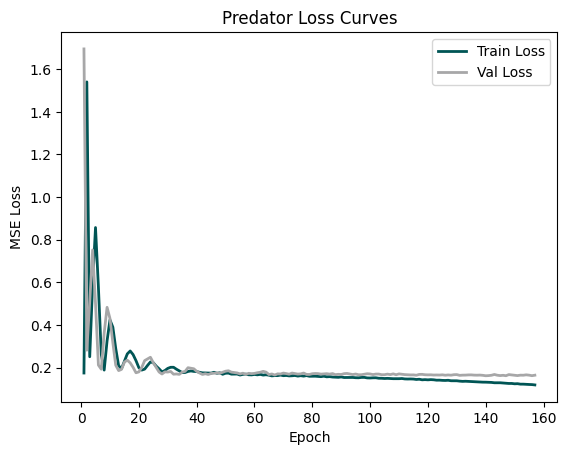

In [15]:
pred_policy, pred_logs = pretrain_policy_with_validation(pred_policy, prey_policy, expert_buffer, role='predator', val_ratio=0.2, pred_bs=1024, prey_bs=4096, epochs=500, lr=1e-3, early_stopping=True, patience=100, device=device)
torch.save(pred_policy, os.path.join(save_dir, "bc_pred_policy.pt"))

with open(os.path.join(save_dir, "bc_pred_logs.pkl"), "wb") as f:
    pickle.dump(pred_logs, f)

[PREY] Epoch 01 | Train Loss: 0.321279 | Val Loss: 1.450028
[PREY] Epoch 02 | Train Loss: 1.399026 | Val Loss: 0.347113
[PREY] Epoch 03 | Train Loss: 0.343221 | Val Loss: 0.807779
[PREY] Epoch 04 | Train Loss: 0.844544 | Val Loss: 0.862478
[PREY] Epoch 05 | Train Loss: 0.898464 | Val Loss: 0.525778
[PREY] Epoch 06 | Train Loss: 0.549266 | Val Loss: 0.330784
[PREY] Epoch 07 | Train Loss: 0.338539 | Val Loss: 0.412187
[PREY] Epoch 08 | Train Loss: 0.404249 | Val Loss: 0.544507
[PREY] Epoch 09 | Train Loss: 0.533329 | Val Loss: 0.565036
[PREY] Epoch 10 | Train Loss: 0.558085 | Val Loss: 0.482358
[PREY] Epoch 11 | Train Loss: 0.473390 | Val Loss: 0.377164
[PREY] Epoch 12 | Train Loss: 0.375474 | Val Loss: 0.332632
[PREY] Epoch 13 | Train Loss: 0.327498 | Val Loss: 0.348148
[PREY] Epoch 14 | Train Loss: 0.349583 | Val Loss: 0.396569
[PREY] Epoch 15 | Train Loss: 0.395189 | Val Loss: 0.423086
[PREY] Epoch 16 | Train Loss: 0.423698 | Val Loss: 0.415636
[PREY] Epoch 17 | Train Loss: 0.411289 |

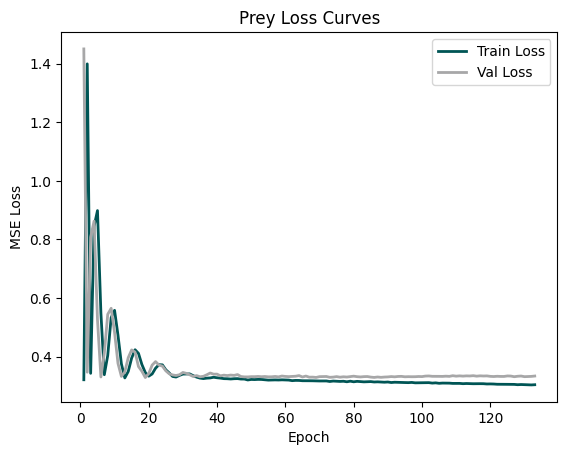

In [16]:
prey_policy, prey_logs = pretrain_policy_with_validation(prey_policy, pred_policy, expert_buffer, role='prey', val_ratio=0.2, pred_bs=1024, prey_bs=4096, epochs=1000, lr=1e-3, early_stopping=True, patience=100, device=device)
torch.save(prey_policy, os.path.join(save_dir, "bc_prey_policy.pt"))

with open(os.path.join(save_dir, "bc_prey_logs.pkl"), "wb") as f:
    pickle.dump(prey_logs, f)

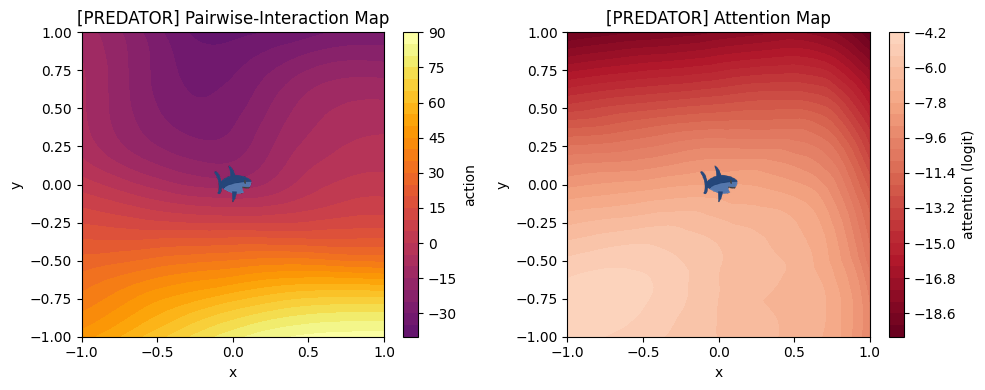

In [17]:
xs, ys, pred_action_map, pred_attn_map = compute_pin_an_maps(pin=pred_policy.pairwise, an=pred_policy.attention)

pred_img_path = rf"..\data\3. Evaluation\images\predator.png"
plot_policy_maps(xs, ys, pred_action_map, pred_attn_map, role="predator", img_path=pred_img_path)

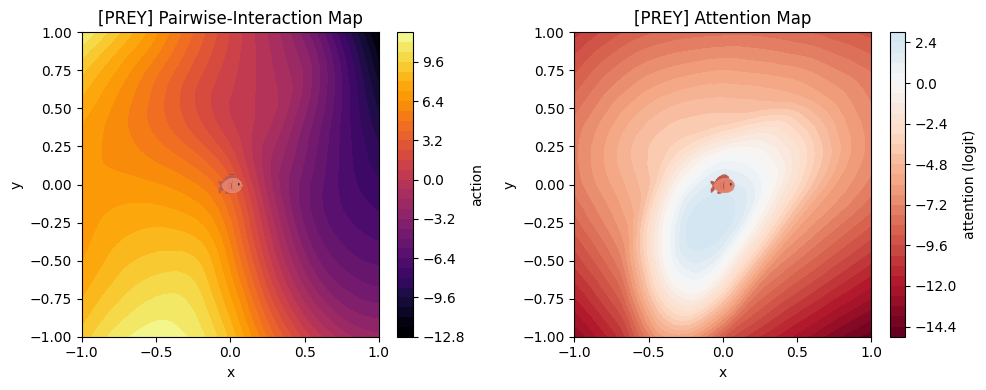

In [18]:
xs, ys, prey_action_map, prey_attn_map = compute_pin_an_maps(pin=prey_policy.prey_pairwise, an=prey_policy.prey_attention)

prey_img_path = rf"..\data\3. Evaluation\images\prey.png"
plot_policy_maps(xs, ys, prey_action_map, prey_attn_map, role="prey", img_path=prey_img_path)

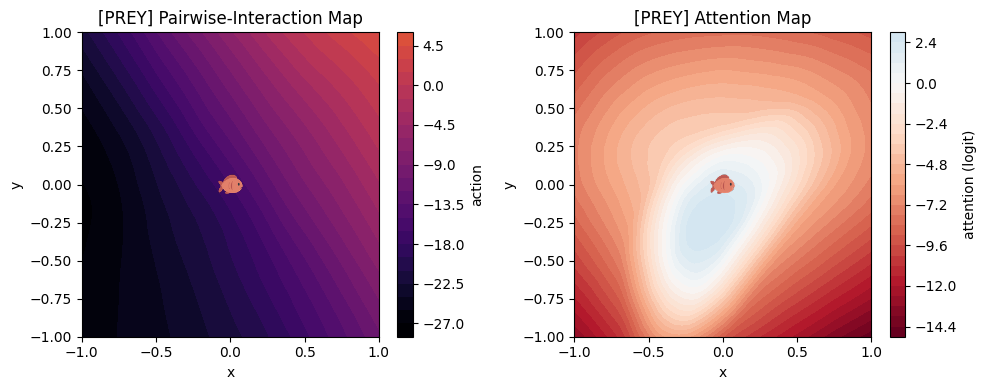

In [19]:
xs, ys, prey_action_map, prey_attn_map = compute_pin_an_maps(pin=prey_policy.pred_pairwise, an=prey_policy.prey_attention)

prey_img_path = rf"..\data\3. Evaluation\images\prey.png"
plot_policy_maps(xs, ys, prey_action_map, prey_attn_map, role="prey", img_path=prey_img_path)

In [10]:
env = parallel_env(use_walls=True, prey_max_velocity=4.0, predator_max_velocity=7.0, prey_count=20)
positions = start_frame_pool.sample(n=1)
env.reset(options=positions)
metrics = run_policies(env, pred_policy, prey_policy)

Press 'q' to end simulation.


In [12]:
import pandas as pd
import numpy as np

df = pd.DataFrame({
    "agg_action":      [np.mean(m) for m in prey_logs["agg_action"]],
    "pred_action":   [np.mean(s) for s in prey_logs["pred_action"]],
    "prey_action": [np.mean(w) for w in prey_logs["prey_action"]],
    "pred_gain": [np.mean(g) for g in prey_logs["pred_gain"]],
})

df

,agg_action,pred_action,prey_action,pred_gain
0,-0.026716,-0.155171,-0.026165,0.004691
1,0.033999,-0.154833,0.035041,0.004691
2,0.001922,-0.101571,0.002625,0.004691
3,-0.010133,-0.202801,-0.008980,0.004691
4,-0.015126,-0.172722,-0.013732,0.004691
...,...,...,...,...
167,-0.018834,-0.146291,-0.018280,0.004691
168,-0.013633,-0.156320,-0.012626,0.004691
169,0.026312,-0.197476,0.027478,0.004691
170,-0.050700,-0.140889,-0.050348,0.004691
